Creamos el dataset

120


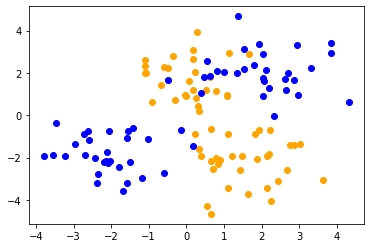

In [1]:
import numpy as np
import matplotlib.pyplot as plt

n_samples = 30 * 4

A = np.array([[np.random.normal(loc=0), np.random.normal(loc=2)] for i in range(n_samples//4)]) 
B = np.array([[np.random.normal(loc=2), np.random.normal(loc=-2)] for i in range(n_samples//4)]) 
C = np.array([[np.random.normal(loc=2), np.random.normal(loc=2)] for i in range(n_samples//4)]) 
D = np.array([[np.random.normal(loc=-2), np.random.normal(loc=-2)] for i in range(n_samples//4)])

feature = np.concatenate([A, B,C,D], axis=0)/4
label = np.concatenate([-np.ones(n_samples // 2), np.ones(n_samples//2)], axis=0)
data = list(zip(feature, label))

np.random.shuffle(data)
print(len(data))
plt.scatter(A[:,0], A[:,1], color = "orange")
plt.scatter(B[:,0], B[:,1], color = "orange")
plt.scatter(C[:,0], C[:,1], color = "blue")
plt.scatter(D[:,0], D[:,1], color = "blue")
plt.show()

In [2]:
import numpy as np

porcentaje_train = 0.5
m = int(porcentaje_train * n_samples)


x_train = np.array([data[i][0] for i in range(m)])
y_train = np.array([data[i][1] for i in range(m)])

x_test = np.array([data[i][0] for i in range(m,n_samples)])
y_test = np.array([data[i][1] for i in range(m,n_samples)])


Procedimiento matemático que sigue el SVM:

- Buscar los $\vec{\alpha}$ que minimicen la función L:

$L = -\sum_{i=0}^{m}\alpha_{i} + \frac{1}{2} \sum_{i=0}^{m} \sum_{j=0}^{m} \alpha_{i} \alpha_{j} f(\vec{x_{i}}) f(\vec{x_{j}}) \vec{x_{i}} \cdot \vec{x_{j}}$

donde $\vec{x_i}$ hace referencia a las características del i-ésimo punto y $f(\vec{x_i})$ a su etiqueta correspondiente.

- A partir de $\vec{\alpha}$ se puede conseguir el hiperplano de clasificación.

¿Cómo introducir aquí funciones Kernel?

Tan solo hay que cambiar la función a minimizar:

$L = -\sum_{i=0}^{m}\alpha_{i} + \frac{1}{2} \sum_{i=0}^{m} \sum_{j=0}^{m} \alpha_{i} \alpha_{j} f(\vec{x_{i}}) f(\vec{x_{j}}) \phi(\vec{x_{i}}) \cdot \phi(\vec{x_{j}})$

Por tanto, lo que haremos será calcular todos lo productos internos a traves del nuestra función de mapeo, es decir, la matriz de Gramm.

In [3]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from time import time
from sklearn import svm
import scipy

n = len(x_train[0])

@qml.template
def feature_map(x):
    
    # ZZMap modificado

    for i in range(2):
        qml.Hadamard(wires = i)


    qml.RZ(2*x[0], wires = 0)
    qml.RZ(2*x[1], wires = 1)
    qml.CNOT(wires = [0,1])
    qml.RZ(2*(np.pi - x[0])*(np.pi - x[1]), wires = 1)
    qml.CNOT(wires = [0,1])
    
    
dev = qml.device("default.qubit", wires = n)      
@qml.qnode(dev)
def circuit(x,y):
    feature_map(y)
    qml.adjoint(feature_map)(x)
    return qml.probs(wires = range(n))

# devuelve el valor final del producto interno
def scalar_product(x,y):
    probs = circuit(x,y)
    return probs[0]



def KernelGramMatrixFull(X1, X2):
    print("Calculando matriz de Gram")


    gram_matrix = np.zeros((X1.shape[0], X2.shape[0]))
    for i, x1 in enumerate(X1):
        print(int(i / len(X1) *100), "%")
        for j, x2 in enumerate(X2):
            
            x1 = x1.flatten()
            x2 = x2.flatten()
            
            gram_matrix[i, j] = scalar_product(x1,x2)
            
    return gram_matrix


from sklearn import svm

clf = svm.SVC(kernel="precomputed")

matrix = KernelGramMatrixFull(x_train,x_train)

print("Entrenando...")
clf.fit(matrix, y_train)

#test
print("Comprobando con test...")

sol = clf.predict(KernelGramMatrixFull(x_test,x_train))

success = 0
for i in range(len(y_test)):
    if sol[i] == y_test[i]:
        success += 1
        
print("Precisión del test: ", success/len(sol)*100, "%")


Calculando matriz de Gram
0 %
1 %
3 %
5 %
6 %
8 %
10 %
11 %
13 %
15 %
16 %
18 %
20 %
21 %
23 %
25 %
26 %
28 %
30 %
31 %
33 %
35 %
36 %
38 %
40 %
41 %
43 %
45 %
46 %
48 %
50 %
51 %
53 %
55 %
56 %
58 %
60 %
61 %
63 %
65 %
66 %
68 %
70 %
71 %
73 %
75 %
76 %
78 %
80 %
81 %
83 %
85 %
86 %
88 %
90 %
91 %
93 %
95 %
96 %
98 %
Entrenando...
Comprobando con test...
Calculando matriz de Gram
0 %
1 %
3 %
5 %
6 %
8 %
10 %
11 %
13 %
15 %
16 %
18 %
20 %
21 %
23 %
25 %
26 %
28 %
30 %
31 %
33 %
35 %
36 %
38 %
40 %
41 %
43 %
45 %
46 %
48 %
50 %
51 %
53 %
55 %
56 %
58 %
60 %
61 %
63 %
65 %
66 %
68 %
70 %
71 %
73 %
75 %
76 %
78 %
80 %
81 %
83 %
85 %
86 %
88 %
90 %
91 %
93 %
95 %
96 %
98 %
Precisión del test:  85.0 %


predicción:


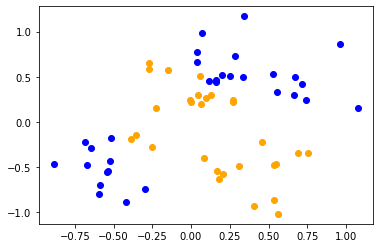

real:


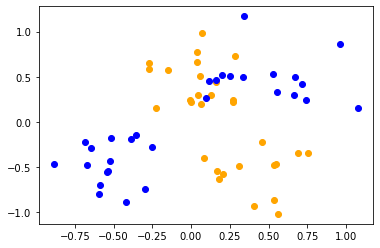

In [4]:
print("predicción:")

for i in range(len(x_test)):
    color = "blue"
    if sol[i] == -1:
        color = "orange"
    
    plt.scatter(x_test[i,0], x_test[i,1], color = color)
    
plt.show()

print("real:")
for i in range(len(x_test)):
    color = "blue"
    if y_test[i] == -1:
        color = "orange"
    
    plt.scatter(x_test[i,0], x_test[i,1], color = color)
    
plt.show()